In [1]:
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.color_palette("husl", 8)
import numpy as np
import pandas as pd
from time import time

%load_ext autoreload
%autoreload 2

In [2]:
from model import DecisionTree, SVM, KNN, KNN_kdtree

In [3]:
df = pd.read_csv('../data/phishing.data', index_col=False, sep=',', names=[f'x{i}' for i in range(1,31)] + ['y'])
df

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x22,x23,x24,x25,x26,x27,x28,x29,x30,y
0,-1,-1,1,1,-1,-1,-1,1,-1,1,...,-1,1,-1,-1,-1,-1,1,1,0,-1
1,1,1,1,1,1,-1,1,1,-1,1,...,0,-1,-1,0,1,0,1,1,0,-1
2,1,-1,1,1,1,-1,-1,1,-1,1,...,0,-1,-1,-1,-1,1,0,0,0,-1
3,1,1,1,1,1,-1,1,1,1,1,...,0,0,-1,-1,-1,1,0,-1,0,-1
4,1,1,-1,1,1,-1,1,-1,-1,1,...,0,0,-1,1,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11050,1,-1,1,-1,1,1,1,-1,-1,-1,...,1,1,-1,1,1,-1,-1,1,0,1
11051,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,0,1,-1,1,1,-1,1,-1
11052,1,1,1,1,1,-1,1,1,-1,1,...,0,-1,-1,1,-1,1,-1,0,0,-1
11053,-1,1,1,1,1,-1,1,-1,1,-1,...,-1,1,-1,-1,-1,1,-1,1,0,-1


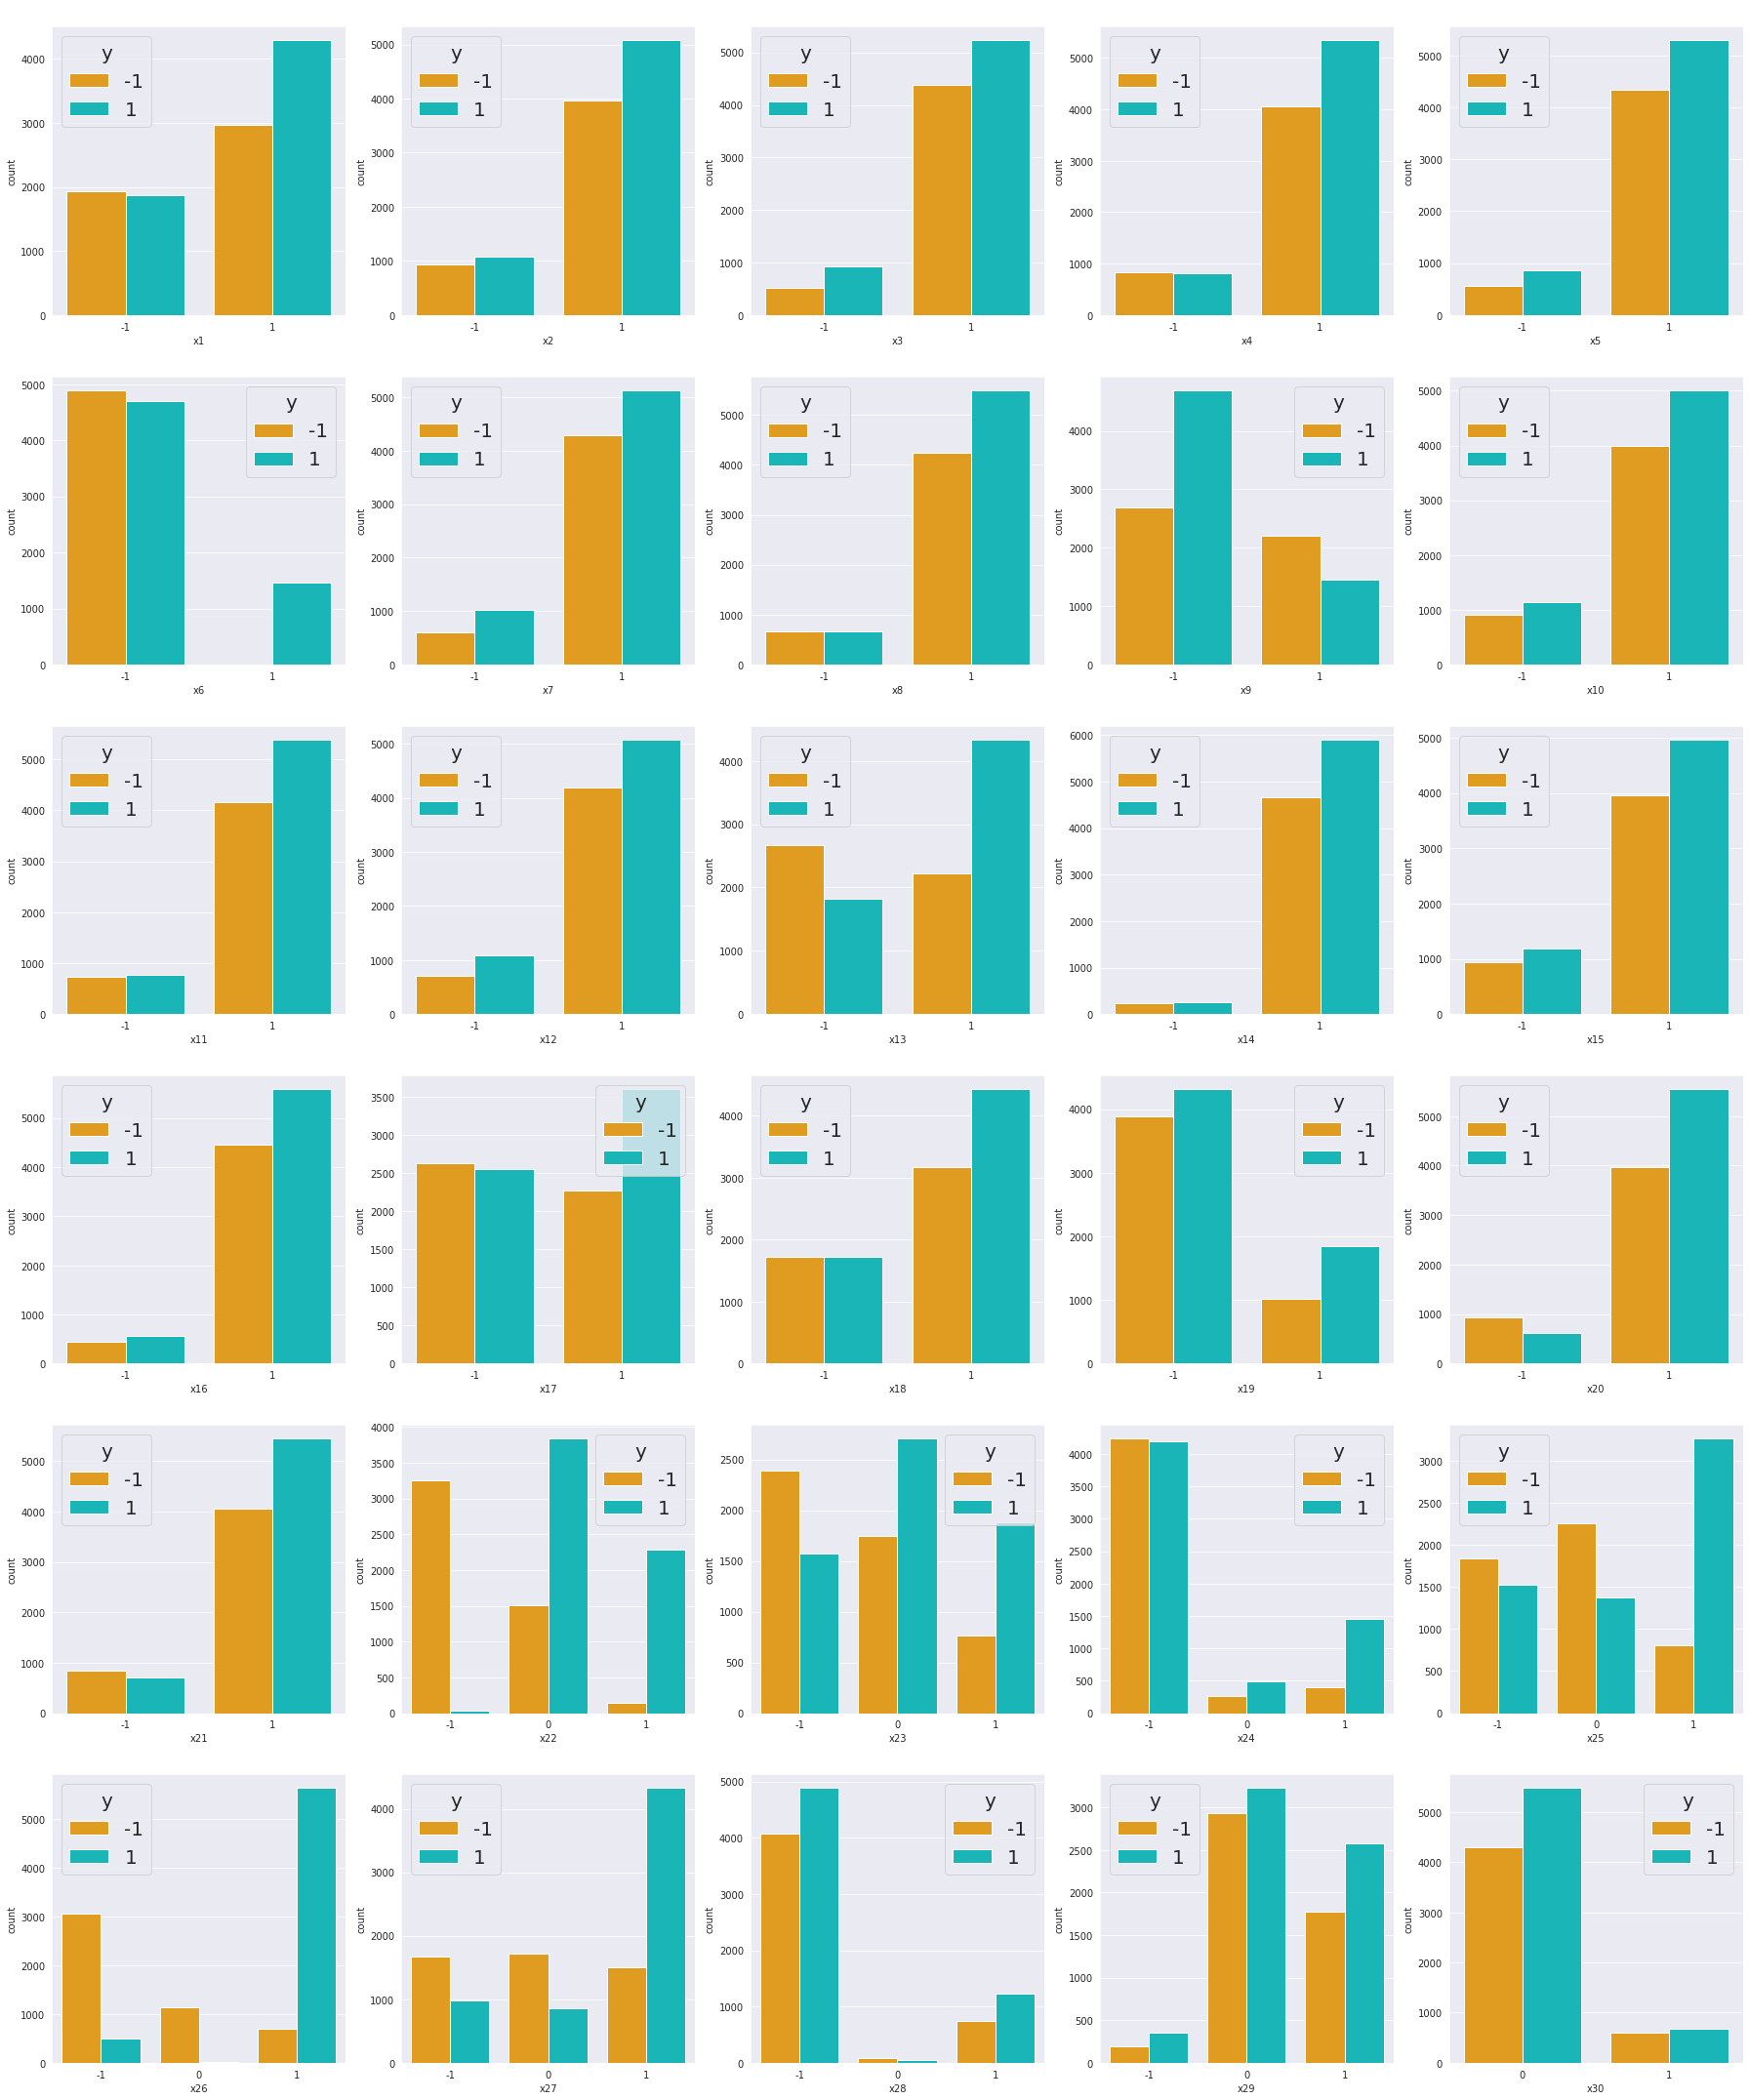

In [4]:
fig, axes = plt.subplots(6, 5, figsize=(25, 30))
axes = axes.flatten()

for i in range(1,31):
    column = f'x{i}'
    sns.countplot(x=df[column], ax=axes[i-1], hue=df['y'], palette={-1: 'orange', 1: '#00CED1'})
    axes[i-1].legend(title='y', title_fontsize='20', fontsize='20')
    axes[i-1].set_title(column, fontsize='20', fontweight='bold', color='white')
plt.tight_layout()

In [4]:
df1 = df.iloc[:, :21] # -1/1
df2 = df.iloc[:, 21:29] # -1/0/1
df2_oh = pd.get_dummies(df2, columns=df2.columns ,prefix=df2.columns, prefix_sep='_').astype(int)
df3 = df.iloc[:, 29:30] # 0/1
df4 = df.iloc[:, 30:] # y
df_norm = pd.concat([df1.replace({-1:0, 1:1}), df2_oh, df3, df4], axis=1)
df = df_norm
df

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x27_0,x27_1,x28_-1,x28_0,x28_1,x29_-1,x29_0,x29_1,x30,y
0,0,0,1,1,0,0,0,1,0,1,...,0,0,0,0,1,0,0,1,0,-1
1,1,1,1,1,1,0,1,1,0,1,...,1,0,0,0,1,0,0,1,0,-1
2,1,0,1,1,1,0,0,1,0,1,...,0,1,0,1,0,0,1,0,0,-1
3,1,1,1,1,1,0,1,1,1,1,...,0,1,0,1,0,1,0,0,0,-1
4,1,1,0,1,1,0,1,0,0,1,...,1,0,0,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11050,1,0,1,0,1,1,1,0,0,0,...,0,0,1,0,0,0,0,1,0,1
11051,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,1,1,0,0,1,-1
11052,1,1,1,1,1,0,1,1,0,1,...,0,1,1,0,0,0,1,0,0,-1
11053,0,1,1,1,1,0,1,0,1,0,...,0,1,1,0,0,0,0,1,0,-1


In [5]:
def partition(df, frac, seed=1234):
    assert 0 < frac <= 1
    df_0 = df[df['y'] == -1].sample(frac=frac, random_state=seed)
    df_1 = df[df['y'] == 1].sample(frac=frac, random_state=seed)
    df_train = pd.concat([df_0, df_1])
    df_test = df.drop(df_train.index)
    return df_train, df_test


df_train, df_test = zip(*[partition(df, 2 / 3, seed=i) for i in range(5)])
print("train: ", df_train)
print("test: ", df_test)

train:  (       x1  x2  x3  x4  x5  x6  x7  x8  x9  x10  ...  x27_0  x27_1  x28_-1  \
6211    0   1   1   1   1   0   1   1   1    1  ...      0      0       1   
89      0   1   0   1   0   0   1   1   0    1  ...      0      1       0   
3196    1   1   1   1   1   0   1   1   0    1  ...      0      1       1   
8249    0   0   1   0   0   0   1   0   1    0  ...      0      1       1   
4773    1   1   1   1   1   0   1   1   0    1  ...      0      0       1   
...    ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...    ...    ...     ...   
10706   1   1   1   1   1   0   1   1   0    1  ...      0      1       1   
2852    1   1   1   0   1   0   1   1   0    1  ...      0      1       0   
6459    1   1   1   1   1   0   1   1   0    1  ...      0      1       1   
8636    1   1   1   1   1   0   1   1   0    1  ...      0      1       1   
3255    1   1   1   1   1   0   1   1   0    1  ...      0      1       1   

       x28_0  x28_1  x29_-1  x29_0  x29_1  x30  y  
6211       0  

In [6]:
def get_data(df):
    y = df['y'].to_numpy()
    y = y.reshape([y.shape[0], 1])

    X = df.drop('y', axis=1)
    X.insert(0, 'x0', [1] * df.shape[0])
    X = X.to_numpy()

    return X, y


train_X, train_y = zip(*[get_data(df_train[i]) for i in range(5)])
test_X, test_y = zip(*[get_data(df_test[i]) for i in range(5)])
# all_X, all_y = zip(*[get_data(df[i]) for i in range(5)])
print("train: ", train_X[0].shape)
print("test: ", test_X[0].shape)

train:  (7370, 47)
test:  (3685, 47)


# Decision Tree

In [149]:
for i in range(5):
    depth = 1
    
    dt_model = DecisionTree(train_X[i], train_y[i], max_depth=depth)
    t0 = time()
    dt_model.train()
    t1 = time()
    train_time = t1-t0

    t0 = time()
    y_pred = dt_model.predict(test_X[i])
    t1 = time()
    pred_time = t1-t0

    y_pred = np.where(y_pred < 0.5, -1, 1)
    
    acc = np.mean(y_pred == test_y[i])
    with open(f'../results/decision_tree_{depth}.out', 'a') as f:
        f.write(str(acc)+'\n')
    with open(f'../results/decision_tree_{depth}.time', 'a') as f:
        f.write(str(train_time)+'\t'+str(pred_time)+'\n')

In [ ]:
for d in [1,2,10,20]:
    with open(f'../results/decision_tree/decision_tree_{d}.out', 'r') as f:
        s = f.readlines()
        vals = [float(v[:-1]) for v in s]
        print(round(sum(vals)/len(vals),4))
    with open(f'../results/decision_tree/decision_tree_{d}.time', 'r') as f:
        s = f.readlines()
        vals = [v[:-1].split('\t') for v in s]
        time1 = [float(v[0]) for v in vals]
        time2 = [float(v[1]) for v in vals]
        # print(vals)
        print(round(sum(time1)/len(time1),4), round(sum(time2)/len(time2),4))

# Support Vector Machine

In [153]:
for i in range(5):
    model = SVM(train_X[i], train_y[i], C=0.001)
    t0 = time()
    model.train(epochs=1000, step_size=0.0001)
    t1 = time()
    train_time = t1-t0

    t0 = time()
    y_pred = model.predict(test_X[i])
    t1 = time()
    pred_time = t1-t0

    acc = np.mean(y_pred == test_y[i])
    with open(f'../results/svm/svm.out', 'a') as f:
        f.write(str(acc)+'\n')
    with open(f'../results/svm/svm.time', 'a') as f:
        f.write(str(train_time)+'\t'+str(pred_time)+'\n')

100%|██████████| 1000/1000 [00:43<00:00, 23.12it/s]


In [158]:
with open(f'../results/svm/svm.out', 'r') as f:
    s = f.readlines()
    vals = [float(v[:-1]) for v in s]
    print(f'[{round(sum(vals)/len(vals),4)}], ', end='')
with open(f'../results/svm/svm.time', 'r') as f:
    s = f.readlines()
    vals = [v[:-1].split('\t') for v in s]
    time1 = [float(v[0]) for v in vals]
    time2 = [float(v[1]) for v in vals]
    print(f'[{round(sum(time1)/len(time1),4)}], [{round(sum(time2)/len(time2),4)}],')

[0.9304], [41.9992], [0.0008],


In [155]:
def plot(weights, X, y, label=''):
    step = 10
    epochs = [ep for ep in range(0, len(weights), step)] + [len(weights)-1]
    y_pred = [np.where(np.dot(X, w) > 0, 1, -1) for w in weights[::step]] + [np.where(np.dot(X, weights[-1]) > 0, 1, -1)]
    acc = [np.mean(y1 == y) for y1 in y_pred]
    # loses = [model.loss(y, model.pred(X, theta)) for theta in thetas[::step]] + [model.loss(y, model.pred(X, thetas[-1]))]
    data = {'epoch': epochs[2:], 'acc': acc[2:]}
    sns.lineplot(data=pd.DataFrame(data), x='epoch', y='acc', label=f'{label}: {np.round(acc[-1],2)}')

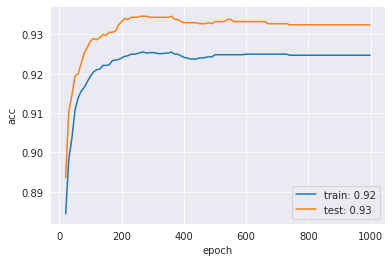

In [150]:
plot(weights, train_X[0], train_y[0], 'train')
plot(weights, test_X[0], test_y[0], 'test')

# k - Nearest Neighbour

In [136]:
for k in [1, 5, 10, 20]:
    for i in range(5):    
        model = KNN(train_X[i], train_y[i])
        t0 = time()
        model.train()
        t1 = time()
        train_time = t1-t0
    
        t0 = time()
        y_pred = model.predict(test_X[i], k)
        t1 = time()
        pred_time = t1-t0
    
        y_pred = np.where(y_pred < 0.5, -1, 1)
    
        acc = np.mean(y_pred == test_y[i])
        with open(f'../results/knn_{k}.out', 'a') as f:
            f.write(str(acc)+'\n')
        with open(f'../results/knn_{k}.time', 'a') as f:
            f.write(str(train_time)+'\t'+str(pred_time)+'\n')

100%|██████████| 3685/3685 [01:17<00:00, 47.45it/s]


In [164]:
for k in [1,5,10,20]:
    print(f'[*{k}*], ', end='')
    with open(f'../results/knn/knn_{k}.out', 'r') as f:
        s = f.readlines()
        vals = [float(v[:-1]) for v in s]
        print(f'[{round(sum(vals)/len(vals),4)}], ', end='')
    with open(f'../results/knn/knn_{k}.time', 'r') as f:
        s = f.readlines()
        vals = [v[:-1].split('\t') for v in s]
        time1 = [float(v[0]) for v in vals]
        time2 = [float(v[1]) for v in vals]
        # print(vals)
        print(f'[{round(sum(time1)/len(time1),4)}], [{round(sum(time2)/len(time2),4)}],')

[*1*], [0.9656], [0.0], [79.9399],
[*5*], [0.9558], [0.0], [78.2672],
[*10*], [0.9467], [0.0], [77.79],
[*20*], [0.9442], [0.0], [77.402],


# kNN - KD-Tree

In [137]:
for k in [1, 5, 10, 20]:
    for i in range(5):
        model = KNN_kdtree(train_X[i], train_y[i])
        t0 = time()
        model.train()
        t1 = time()
        train_time = t1-t0

        t0 = time()
        y_pred = model.predict(test_X[i], k)
        t1 = time()
        pred_time = t1-t0

        y_pred = np.where(y_pred < 0.5, -1, 1)

        acc = np.mean(y_pred == test_y[i])
        with open(f'../results/kdtree_{k}.out', 'a') as f:
            f.write(str(acc)+'\n')
        with open(f'../results/kdtree_{k}.time', 'a') as f:
            f.write(str(train_time)+'\t'+str(pred_time)+'\n')

100%|██████████| 3685/3685 [01:58<00:00, 31.01it/s]


In [166]:
for k in [1,5,10,20]:
    print(f'[*{k}*], ', end='')
    with open(f'../results/kdtree/kdtree_{k}.out', 'r') as f:
        s = f.readlines()
        vals = [float(v[:-1]) for v in s]
        print(f'[{round(sum(vals)/len(vals),4)}], ', end='')
    with open(f'../results/kdtree/kdtree_{k}.time', 'r') as f:
        s = f.readlines()
        vals = [v[:-1].split('\t') for v in s]
        time1 = [float(v[0]) for v in vals]
        time2 = [float(v[1]) for v in vals]
        print(f'[{round(sum(time1)/len(time1),4)}], [{round(sum(time2)/len(time2),4)}],')

[*1*], [0.9647], [0.1572], [73.4703],
[*5*], [0.9537], [0.1742], [103.5071],
[*10*], [0.9462], [0.1589], [114.8301],
[*20*], [0.9401], [0.1596], [118.2375],
